In [1]:
# This notebook trains and evaluates supervised machine-learning models
# to predict serious psychological distress (K6SPD_A) using NHIS 2021–2023 adult data.
# Models evaluated: Decision Tree, Random Forest, Gradient Boosting, KNN,
# Logistic Regression, SVM, and Categorical Naive Bayes.

import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC




In [3]:
# This cell loads the combined NHIS dataset (2021–2023) created during data preparation.
# Check workspace first, then OneDrive project folder.
import os
combined_local = 'nhis_2021_2023_combined.csv'
combined_onedrive = os.path.join(os.path.expanduser('~'), 'OneDrive', 'Documents', 'CSST MASTERS PROJECT', 'nhis_2021_2023_combined.csv')
if os.path.exists(combined_local):
    df = pd.read_csv(combined_local)
    print(f'Loaded df from {combined_local}')
elif os.path.exists(combined_onedrive):
    df = pd.read_csv(combined_onedrive)
    print(f'Loaded df from {combined_onedrive}')
else:
    raise FileNotFoundError('nhis_2021_2023_combined.csv not found in workspace or OneDrive CSST MASTERS PROJECT folder')
print("Dataset shape:", df.shape)
df.head()


Loaded df from nhis_2021_2023_combined.csv
Dataset shape: (86655, 821)


,ACUHLTH_A,ACUPAIN_A,ACU_A,ADVACTIVE_A,AFNOW,AFVETTRN_A,AFVET_A,AGE65,AGEP_A,AHEARST1_A,...,YOGABRTH_A,YOGAHLTH_A,YOGAMED_A,YOGAPAIN_A,YOGA_A,YRSINUS_A,ZOSTAVAX1_A,ZOSTAVXYRP_A,ZOSTAWHEN_A,eRECTYPE
0,NaN,NaN,NaN,NaN,2.0,NaN,2,NaN,50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,2.0,NaN,2,NaN,53,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,2.0,2.0,1,NaN,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,2,NaN,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,2.0,NaN,8,NaN,25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# This cell sets the target outcome to K6SPD_A and inspects its raw coding.

TARGET = "K6SPD_A"
if TARGET not in df.columns:
    raise ValueError(f"{TARGET} not found in dataset.")

df[TARGET].value_counts(dropna=False).head(20)


K6SPD_A
NaN    57173
2.0    27599
1.0     1012
8.0      871
Name: count, dtype: int64

In [5]:
# This cell maps NHIS yes/no codes to binary:
# 1 = Yes -> 1, 2 = No -> 0, others -> missing.

def nhis_yesno_to_binary(x):
    if x == 1: return 1
    if x == 2: return 0
    return np.nan

df["_target_bin"] = df[TARGET].apply(nhis_yesno_to_binary)
df = df[df["_target_bin"].notna()].copy()
df["_target_bin"] = df["_target_bin"].astype(int)

df["_target_bin"].value_counts()


_target_bin
0    27599
1     1012
Name: count, dtype: int64

In [6]:
# This cell selects a manageable set of predictors for modelling.
# You can expand this list later once your pipeline is stable.

candidate_predictors = [
    # Demographics / SES
    "AGEP_A", "SEX_A", "REGION", "URBRRL",
    "RACEALLP_A", "HISP_A", "EDUCP_A", "MARITAL_A",
    # Health status / conditions
    "PHSTAT_A", "HYPEV_A", "CHLEV_A", "DIBEV_A",
    "ARTHEV_A", "COPDEV_A",
    # Healthcare access
    "COVER_A", "NOTCOV_A",
    # Survey year
    "SRVY_YR"
]

predictors = [c for c in candidate_predictors if c in df.columns]
if len(predictors) == 0:
    raise ValueError("No predictors found. Check your column names.")

X = df[predictors].copy()
y = df["_target_bin"].copy()

print("Predictors used:", predictors)
print("X shape:", X.shape, "y shape:", y.shape)


Predictors used: ['AGEP_A', 'SEX_A', 'REGION', 'URBRRL', 'RACEALLP_A', 'HISP_A', 'EDUCP_A', 'MARITAL_A', 'PHSTAT_A', 'HYPEV_A', 'CHLEV_A', 'DIBEV_A', 'ARTHEV_A', 'COPDEV_A', 'COVER_A', 'NOTCOV_A', 'SRVY_YR']
X shape: (28611, 17) y shape: (28611,)


In [7]:
# This cell splits the dataset into train and test sets using stratification.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))


Train class balance:
 _target_bin
0    0.964648
1    0.035352
Name: proportion, dtype: float64
Test class balance:
 _target_bin
0    0.964585
1    0.035415
Name: proportion, dtype: float64


In [8]:
# This cell creates preprocessing pipelines:
# - Numeric: median imputation + scaling
# - Categorical: most frequent imputation + one-hot encoding

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

numeric_features, categorical_features


(['AGEP_A',
  'SEX_A',
  'REGION',
  'URBRRL',
  'RACEALLP_A',
  'HISP_A',
  'EDUCP_A',
  'MARITAL_A',
  'PHSTAT_A',
  'HYPEV_A',
  'CHLEV_A',
  'DIBEV_A',
  'ARTHEV_A',
  'COPDEV_A',
  'COVER_A',
  'NOTCOV_A',
  'SRVY_YR'],
 [])

In [9]:
# This cell defines six ML models that work well with one-hot encoded features.

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM (RBF)": SVC(probability=True, random_state=42)
}

pipelines = {
    name: Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    for name, model in models.items()
}


In [10]:
# This cell trains each model and computes standard evaluation metrics.

results = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    y_prob = None
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    })

results_df = pd.DataFrame(results).sort_values("ROC_AUC", ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,Gradient Boosting,0.964119,0.441176,0.049342,0.088757,0.822764
4,Logistic Regression,0.963886,0.200000,0.006579,0.012739,0.813362
1,Random Forest,0.964469,0.470588,0.026316,0.049844,0.771065
3,KNN,0.964119,0.166667,0.003289,0.006452,0.626729
5,SVM (RBF),0.964585,0.000000,0.000000,0.000000,0.618570
0,Decision Tree,0.929404,0.120603,0.157895,0.136752,0.557354


In [11]:
# This cell prints confusion matrices and classification reports for each model.

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    print("\n======", name, "======")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))



====== Decision Tree ======
Confusion Matrix:
 [[7930  350]
 [ 256   48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      8280
           1       0.12      0.16      0.14       304

    accuracy                           0.93      8584
   macro avg       0.54      0.56      0.55      8584
weighted avg       0.94      0.93      0.93      8584


====== Random Forest ======
Confusion Matrix:
 [[8271    9]
 [ 296    8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      8280
           1       0.47      0.03      0.05       304

    accuracy                           0.96      8584
   macro avg       0.72      0.51      0.52      8584
weighted avg       0.95      0.96      0.95      8584


====== Gradient Boosting ======
Confusion Matrix:
 [[8261   19]
 [ 289   15]]

Classification Report:
               precision    recall  f1-scor

In [12]:
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    print("\n======", name, "======")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


====== Decision Tree ======
Confusion Matrix:
 [[7930  350]
 [ 256   48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      8280
           1       0.12      0.16      0.14       304

    accuracy                           0.93      8584
   macro avg       0.54      0.56      0.55      8584
weighted avg       0.94      0.93      0.93      8584


====== Random Forest ======
Confusion Matrix:
 [[8271    9]
 [ 296    8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      8280
           1       0.47      0.03      0.05       304

    accuracy                           0.96      8584
   macro avg       0.72      0.51      0.52      8584
weighted avg       0.95      0.96      0.95      8584


====== Gradient Boosting ======
Confusion Matrix:
 [[8261   19]
 [ 289   15]]

Classification Report:
               precision    recall  f1-scor

<Figure size 640x480 with 0 Axes>

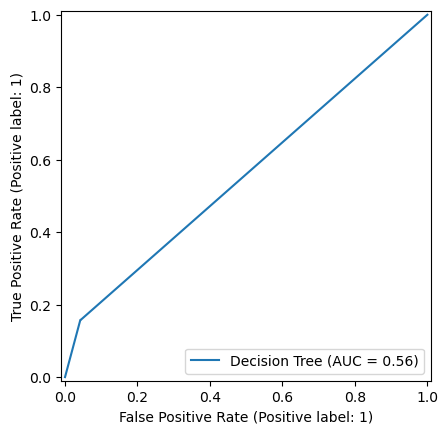

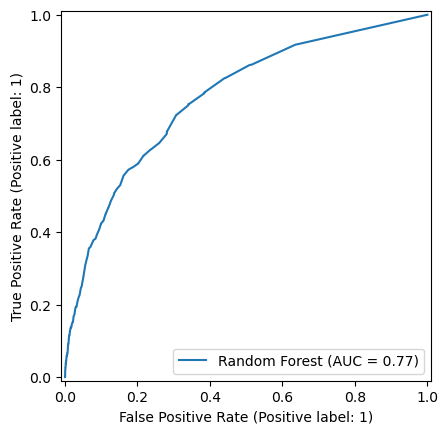

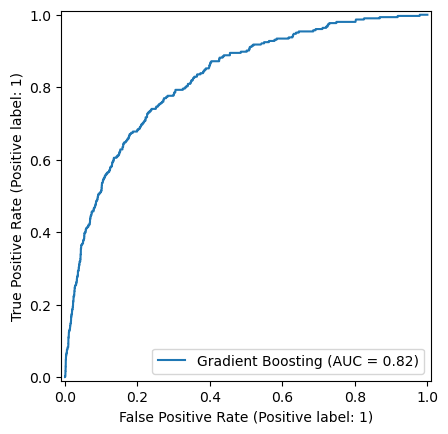

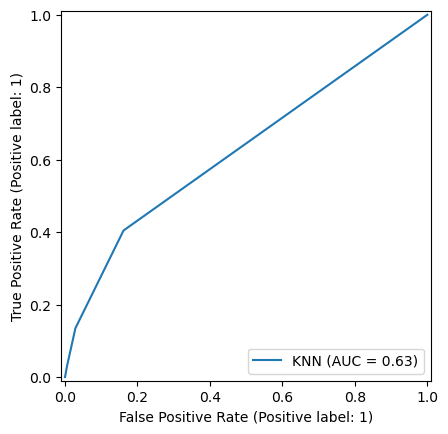

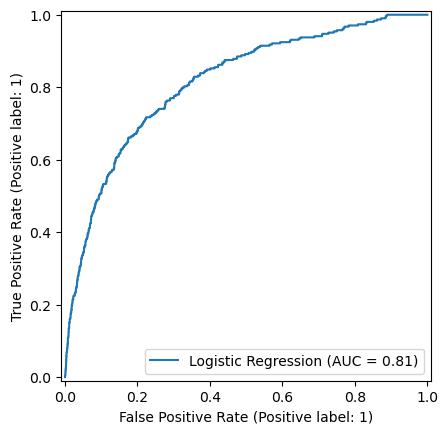

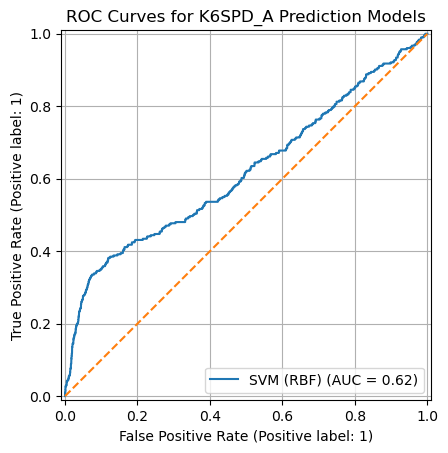

In [13]:
# This cell plots ROC curves for models that provide predicted probabilities.

plt.figure()
for name, pipe in pipelines.items():
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves for K6SPD_A Prediction Models")
plt.grid(True)
plt.show()


In [14]:
# CategoricalNB removed: this notebook now uses the six main pipelines defined earlier.

In [15]:
# This cell provides a simple robustness check using 5-fold stratified cross-validation.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_summary = []
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
    cv_summary.append({
        "Model": name,
        "CV_ROC_AUC_mean": scores.mean(),
        "CV_ROC_AUC_std": scores.std()
    })

cv_results_df = pd.DataFrame(cv_summary).sort_values("CV_ROC_AUC_mean", ascending=False)
cv_results_df

,Model,CV_ROC_AUC_mean,CV_ROC_AUC_std
2,Gradient Boosting,0.825339,0.004748
4,Logistic Regression,0.811918,0.005442
1,Random Forest,0.766504,0.009125
3,KNN,0.624472,0.003237
5,SVM (RBF),0.594472,0.025600
0,Decision Tree,0.542161,0.009376


<Figure size 640x480 with 0 Axes>

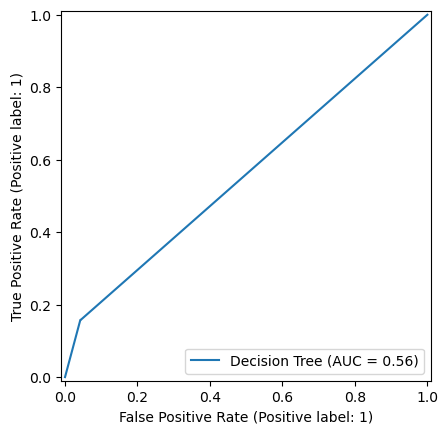

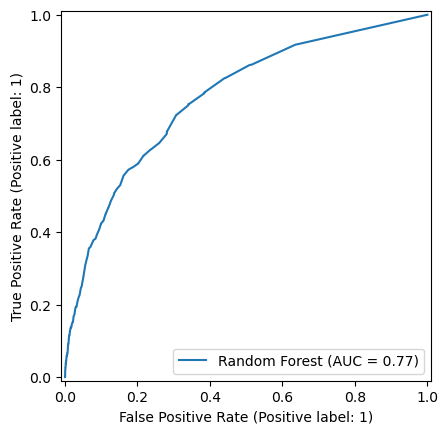

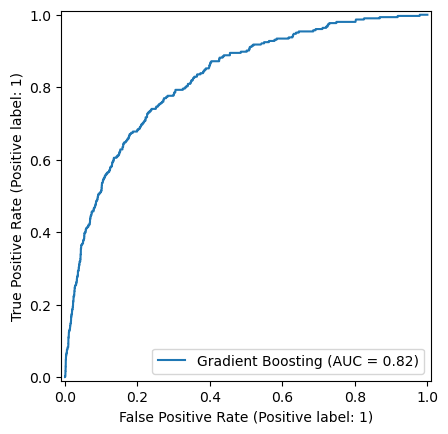

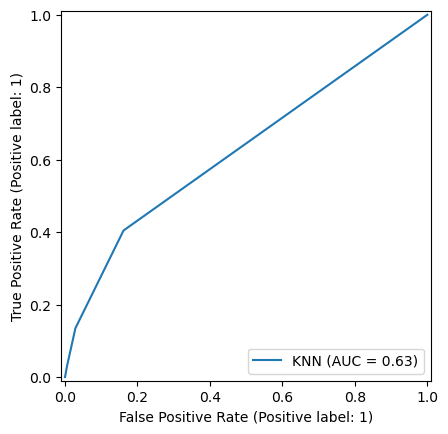

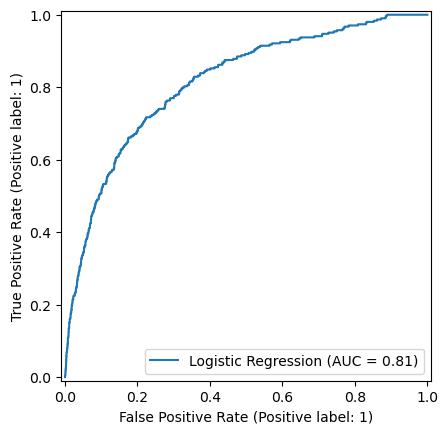

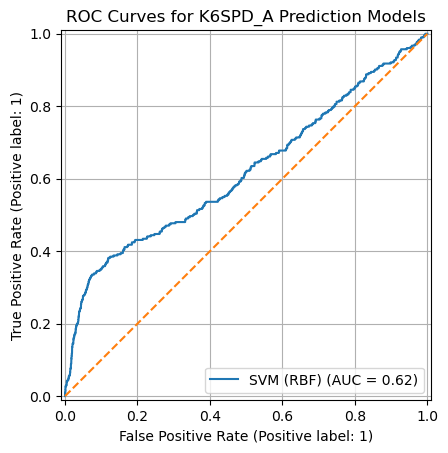

Saved: model_results_comparison.csv
Saved: fig_roc_models_k6spd.png
Saved: best_model_pipeline_k6spd.joblib (Best model: Gradient Boosting)


In [16]:
# This cell saves key outputs (tables, figures, and best model) for reporting and dashboard deployment.

import joblib

# Save model comparison table
results_df.to_csv("model_results_comparison.csv", index=False)

# Save ROC curves figure
plt.figure()
for name, pipe in pipelines.items():
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves for K6SPD_A Prediction Models")
plt.grid(True)
plt.savefig("fig_roc_models_k6spd.png", dpi=300, bbox_inches="tight")
plt.show()

# Save best model pipeline (based on highest ROC_AUC)
best_model_name = results_df.iloc[0]["Model"]
best_pipe = pipelines[best_model_name]
joblib.dump(best_pipe, "best_model_pipeline_k6spd.joblib")

print("Saved: model_results_comparison.csv")
print("Saved: fig_roc_models_k6spd.png")
print(f"Saved: best_model_pipeline_k6spd.joblib (Best model: {best_model_name})")


In [17]:
# --- SHAP: Save values, transformed data, and explainer for use in SHAP notebook ---
import shap
import numpy as np

# Only run this for tree-based models (RandomForest, GradientBoosting, etc.)
if hasattr(best_pipe.named_steps['model'], 'feature_importances_'):
    preprocessor = best_pipe.named_steps['preprocess']
    clf = best_pipe.named_steps['model']
    # Use the same features as in training
    X_all = df[preprocessor.feature_names_in_] if hasattr(preprocessor, 'feature_names_in_') else X
    X_transformed = preprocessor.transform(X_all)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_transformed)
    # Save SHAP values
    np.save('shap_values.npy', shap_values)
    # Save transformed data
    import pandas as pd
    pd.DataFrame(X_transformed).to_csv('X_transformed.csv', index=False)
    # Save explainer
    import joblib
    joblib.dump(explainer, 'shap_explainer.joblib')
    print('Saved: shap_values.npy, X_transformed.csv, shap_explainer.joblib')

Saved: shap_values.npy, X_transformed.csv, shap_explainer.joblib
